In [1]:
import pandas as pd

# Column names based on the UCI dataset documentation
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

# Load the dataset
df = pd.read_csv("data/adult.csv", header=None, names=column_names, na_values=' ?')

# Display the first 5 rows
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income


In [2]:
# Drop rows with missing values
df_clean = df.dropna()

# Confirm the shape before and after
print(f"Original shape: {df.shape}")
print(f"After cleaning: {df_clean.shape}")


Original shape: (0, 15)
After cleaning: (0, 15)


In [3]:
# Count values for sensitive attributes
print("Sex distribution:")
print(df_clean['sex'].value_counts())

print("\nRace distribution:")
print(df_clean['race'].value_counts())

print("\nIncome distribution:")
print(df_clean['income'].value_counts())


Sex distribution:
Series([], Name: count, dtype: int64)

Race distribution:
Series([], Name: count, dtype: int64)

Income distribution:
Series([], Name: count, dtype: int64)


In [4]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from sklearn.preprocessing import LabelEncoder

# Encode binary labels: income and sex
df_encoded = df_clean.copy()
df_encoded['income'] = LabelEncoder().fit_transform(df_encoded['income'])  # 0 = <=50K, 1 = >50K
df_encoded['sex'] = LabelEncoder().fit_transform(df_encoded['sex'])        # 0 = Female, 1 = Male

# Define privileged and unprivileged groups
privileged_groups = [{'sex': 1}]       # Male
unprivileged_groups = [{'sex': 0}]     # Female

# Convert to AIF360 BinaryLabelDataset
dataset = BinaryLabelDataset(
    df=df_encoded,
    label_names=['income'],
    protected_attribute_names=['sex']
)


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [5]:
# Basic fairness metrics
metric = BinaryLabelDatasetMetric(dataset, 
                                   privileged_groups=privileged_groups,
                                   unprivileged_groups=unprivileged_groups)

print("Statistical Parity Difference:", metric.statistical_parity_difference())
print("Disparate Impact:", metric.disparate_impact())


Statistical Parity Difference: nan
Disparate Impact: nan


c:\Users\CAPACITI-JHB\Downloads\bias-audit-report\venv\Lib\site-packages\aif360\metrics\binary_label_dataset_metric.py:105: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_positives(privileged=privileged)


In [6]:
from aif360.algorithms.preprocessing import Reweighing

# Reweighing transforms the training dataset to reduce bias
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

# Fit and transform the dataset
reweighed_dataset = RW.fit_transform(dataset)

# Let’s compare some metrics again
metric_rw = BinaryLabelDatasetMetric(reweighed_dataset,
                                     unprivileged_groups=unprivileged_groups,
                                     privileged_groups=privileged_groups)

print("After Reweighing:")
print("Statistical Parity Difference:", metric_rw.statistical_parity_difference())
print("Disparate Impact:", metric_rw.disparate_impact())


After Reweighing:
Statistical Parity Difference: nan
Disparate Impact: nan


c:\Users\CAPACITI-JHB\Downloads\bias-audit-report\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:66: RuntimeWarning: invalid value encountered in scalar divide
  self.w_p_fav = n_fav*n_p / (n*n_p_fav)
c:\Users\CAPACITI-JHB\Downloads\bias-audit-report\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:67: RuntimeWarning: invalid value encountered in scalar divide
  self.w_p_unfav = n_unfav*n_p / (n*n_p_unfav)
c:\Users\CAPACITI-JHB\Downloads\bias-audit-report\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:68: RuntimeWarning: invalid value encountered in scalar divide
  self.w_up_fav = n_fav*n_up / (n*n_up_fav)
c:\Users\CAPACITI-JHB\Downloads\bias-audit-report\venv\Lib\site-packages\aif360\algorithms\preprocessing\reweighing.py:69: RuntimeWarning: invalid value encountered in scalar divide
  self.w_up_unfav = n_unfav*n_up / (n*n_up_unfav)


In [7]:
# Compare original and reweighed metrics side-by-side
comparison = pd.DataFrame({
    "Metric": ["Statistical Parity Difference", "Disparate Impact"],
    "Before Mitigation": [
        metric.statistical_parity_difference(),
        metric.disparate_impact()
    ],
    "After Reweighing": [
        metric_rw.statistical_parity_difference(),
        metric_rw.disparate_impact()
    ]
})

comparison


,Metric,Before Mitigation,After Reweighing
0,Statistical Parity Difference,NaN,NaN
1,Disparate Impact,NaN,NaN


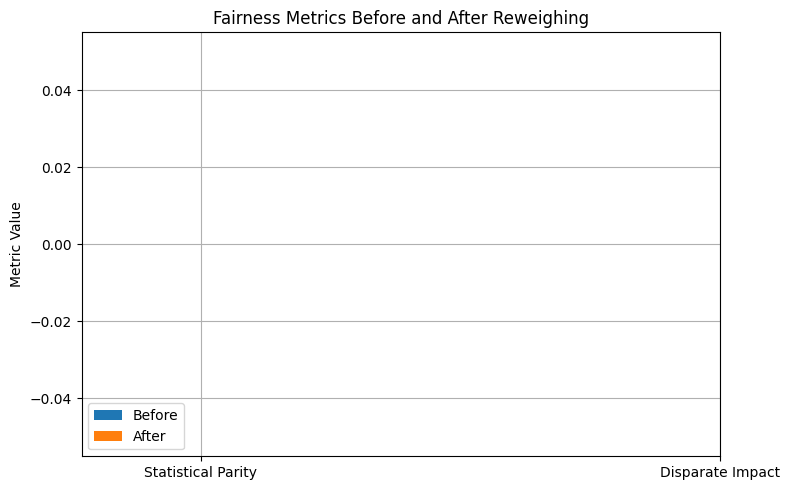

In [8]:
import matplotlib.pyplot as plt

# Bar chart comparison
labels = ["Statistical Parity", "Disparate Impact"]
before = [metric.statistical_parity_difference(), metric.disparate_impact()]
after = [metric_rw.statistical_parity_difference(), metric_rw.disparate_impact()]

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x, before, width, label='Before')
ax.bar([i + width for i in x], after, width, label='After')

ax.set_ylabel('Metric Value')
ax.set_title('Fairness Metrics Before and After Reweighing')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
